# Image De-Hazing 
## AMEF Testing: Various Clip Ranges and Gamma Levels

In [1]:
%matplotlib inline
# %matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA # Principle Component Analysis
from sklearn.cluster import AgglomerativeClustering # hierarchical agglomerative clustering
from sklearn.cluster import KMeans # k-means
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix #model evaluation
from sklearn.metrics import silhouette_score


from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.mixture import GaussianMixture # EM/GMM
from sklearn.utils import shuffle

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

from mizani.breaks import date_breaks
from mizani.formatters import date_format

import math

pd.set_option('display.max_rows', 100)



np.random.seed(11132009)

In [2]:
data = pd.read_csv("../eval_20_Jul_2021_13_36_29.csv")
data.head(7)

,Dataset,Filename,Size(Pixels),Method,MSE,SSIM,ClipRange,NumGamma,Time
0,D-HAZY-MID,Adirondack_im0,17176320,HAZY,0.093500,0.686573,0.000,0.0,NaN
1,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.045760,0.768561,0.005,3.0,7.339993
2,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.033644,0.816057,0.005,4.0,8.067115
3,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.026954,0.846020,0.005,5.0,8.692747
4,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.023657,0.862817,0.005,6.0,9.462002
5,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.020338,0.871445,0.005,7.0,11.543515
6,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.018654,0.874759,0.005,8.0,13.631208


In [3]:
crs = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
ngs = [3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

is_cr_ng = [[0 for x in range(6)] for y in range(6)] 
data_cr_ng = [[0 for x in range(6)] for y in range(6)]

is_hazy = data["Method"] == "HAZY"
data_hazy = data[is_hazy]

for i, cr in enumerate(crs):
    for j, ng in enumerate(ngs):
        is_cr_ng[i][j] = (data["ClipRange"] == cr) & (data["NumGamma"] == ng)
        data_cr_ng[i][j] = data[is_cr_ng[i][j]]



# is_amef_005 = data["Method"] == "AMEF_0.005"
# is_amef_010 = data["Method"] == "AMEF_0.01"
# is_amef_015 = data["Method"] == "AMEF_0.015"
# is_amef_mod_001 = data["Method"] == "AMEF_Modified_0.001"
# is_amef_mod_003 = data["Method"] == "AMEF_Modified_0.003"
# is_amef_mod_005 = data["Method"] == "AMEF_Modified_0.005"


# data_amef_005 = data[is_amef_005]
# data_amef_010 = data[is_amef_010]
# data_amef_015 = data[is_amef_015]
# data_amef_mod_001 = data[is_amef_mod_001]
# data_amef_mod_003 = data[is_amef_mod_003]
# data_amef_mod_005 = data[is_amef_mod_005]

## Dataset Names:
- D-HAZY-MID
- HTTS-SYN
- I-HAZY-NTIRE-2018
- O-HAZY-NTIRE-2018

In [4]:
data_cr_ng[1][4].head()

,Dataset,Filename,Size(Pixels),Method,MSE,SSIM,ClipRange,NumGamma,Time
11,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.021232,0.858920,0.01,7.0,11.458892
48,D-HAZY-MID,Backpack_im0,17781120,AMEF,0.022749,0.849503,0.01,7.0,11.880043
85,D-HAZY-MID,Bicycle1_im0,17999712,AMEF,0.013459,0.901293,0.01,7.0,11.762596
122,D-HAZY-MID,Cable_im0,16641792,AMEF,0.166506,0.592153,0.01,7.0,10.868431
159,D-HAZY-MID,Classroom1_im0,17280000,AMEF,0.039906,0.707140,0.01,7.0,11.519225


In [5]:
means_hazy = {
    "Dataset" : ["D-HAZY-MID",
                 "HTTS-SYN",
                 "I-HAZY-NTIRE-2018",
                 "O-HAZY-NTIRE-2018",
                 "Total"],
    "Method" : ["HAZY"] * 5,
    "ClipRange" : [0] * 5,
    "NumGamma" : [0] * 5,
    "mean_mse" : [0] * 5,
    "mean_ssim" : [0] * 5,
    "stand_dev_mse" : [0] * 5,
    "stand_dev_ssim" : [0] * 5,
}

means = [[dict(means_hazy) for x in range(6)] for y in range(6)] 

# for index, row in data_hazy.iterrows():
means_hazy["mean_mse"][4] = data_hazy["MSE"].mean()
means_hazy["mean_ssim"][4] = data_hazy["SSIM"].mean()
means_hazy["stand_dev_mse"][4] = data_hazy["MSE"].std()
means_hazy["stand_dev_ssim"][4] = data_hazy["SSIM"].std()

is_dhz = data_hazy["Dataset"] == "D-HAZY-MID"
dhz = data_hazy[is_dhz]
means_hazy["mean_mse"][0] = dhz["MSE"].mean()
means_hazy["mean_ssim"][0] = dhz["SSIM"].mean()
means_hazy["stand_dev_mse"][0] = dhz["MSE"].std()
means_hazy["stand_dev_ssim"][0] = dhz["SSIM"].std()

is_hts = data_hazy["Dataset"] == "HTTS-SYN"
hts = data_hazy[is_hts]
means_hazy["mean_mse"][1] = hts["MSE"].mean()
means_hazy["mean_ssim"][1] = hts["SSIM"].mean()
means_hazy["stand_dev_mse"][1] = hts["MSE"].std()
means_hazy["stand_dev_ssim"][1] = hts["SSIM"].std()

is_ihz = data_hazy["Dataset"] == "I-HAZY-NTIRE-2018"
ihz = data_hazy[is_ihz]
means_hazy["mean_mse"][2] = ihz["MSE"].mean()
means_hazy["mean_ssim"][2] = ihz["SSIM"].mean()
means_hazy["stand_dev_mse"][2] = ihz["MSE"].std()
means_hazy["stand_dev_ssim"][2] = ihz["SSIM"].std()

is_ohz = data_hazy["Dataset"] == "O-HAZY-NTIRE-2018"
ohz = data_hazy[is_ohz]
means_hazy["mean_mse"][3] = ohz["MSE"].mean()
means_hazy["mean_ssim"][3] = ohz["SSIM"].mean()
means_hazy["stand_dev_mse"][3] = ohz["MSE"].std()
means_hazy["stand_dev_ssim"][3] = ohz["SSIM"].std()

means_hazy = pd.DataFrame(means_hazy)
means_hazy.head()


,Dataset,Method,ClipRange,NumGamma,mean_mse,mean_ssim,stand_dev_mse,stand_dev_ssim
0,D-HAZY-MID,HAZY,0,0,0.125663,0.636021,0.080773,0.136072
1,HTTS-SYN,HAZY,0,0,0.041467,0.775688,0.028023,0.119017
2,I-HAZY-NTIRE-2018,HAZY,0,0,0.046588,0.603014,0.032631,0.142398
3,O-HAZY-NTIRE-2018,HAZY,0,0,0.050364,0.379695,0.026709,0.201711
4,Total,HAZY,0,0,0.064527,0.532982,0.054928,0.215104


In [6]:
for i, cr in enumerate(crs):
    for j, ng in enumerate(ngs):
        means[i][j]["Method"] = ["AMEF"] * 5
        means[i][j]["ClipRange"] = [cr] * 5
        means[i][j]["NumGamma"] = [ng] * 5
        means[i][j]["mean_mse"] = [0] * 5
        means[i][j]["mean_ssim"] = [0] * 5
        means[i][j]["stand_dev_mse"] = [0] * 5
        means[i][j]["stand_dev_ssim"] = [0] * 5
        
        means[i][j]["mean_mse"][4] = data_cr_ng[i][j]["MSE"].mean()
        means[i][j]["mean_ssim"][4] = data_cr_ng[i][j]["SSIM"].mean()
        means[i][j]["stand_dev_mse"][0] = data_cr_ng[i][j]["MSE"].std()
        means[i][j]["stand_dev_ssim"][0] = data_cr_ng[i][j]["SSIM"].std()

        is_dhz = data_cr_ng[i][j]["Dataset"] == "D-HAZY-MID"
        dhz = data_cr_ng[i][j][is_dhz]
        means[i][j]["mean_mse"][0] = dhz["MSE"].mean()
        means[i][j]["mean_ssim"][0] = dhz["SSIM"].mean()
        means[i][j]["stand_dev_mse"][0] = dhz["MSE"].std()
        means[i][j]["stand_dev_ssim"][0] = dhz["SSIM"].std()

        is_hts = data_cr_ng[i][j]["Dataset"] == "HTTS-SYN"
        hts = data_cr_ng[i][j][is_hts]
        means[i][j]["mean_mse"][1] = hts["MSE"].mean()
        means[i][j]["mean_ssim"][1] = hts["SSIM"].mean()
        means[i][j]["stand_dev_mse"][1] = hts["MSE"].std()
        means[i][j]["stand_dev_ssim"][1] = hts["SSIM"].std()

        is_ihz = data_cr_ng[i][j]["Dataset"] == "I-HAZY-NTIRE-2018"
        ihz = data_cr_ng[i][j][is_ihz]
        means[i][j]["mean_mse"][2] = ihz["MSE"].mean()
        means[i][j]["mean_ssim"][2] = ihz["SSIM"].mean()
        means[i][j]["stand_dev_mse"][2] = ihz["MSE"].std()
        means[i][j]["stand_dev_ssim"][2] = ihz["SSIM"].std()

        is_ohz = data_cr_ng[i][j]["Dataset"] == "O-HAZY-NTIRE-2018"
        ohz = data_cr_ng[i][j][is_ohz]
        means[i][j]["mean_mse"][3] = ohz["MSE"].mean()
        means[i][j]["mean_ssim"][3] = ohz["SSIM"].mean()
        means[i][j]["stand_dev_mse"][3] = ohz["MSE"].std()
        means[i][j]["stand_dev_ssim"][3] = ohz["SSIM"].std()

In [7]:
means_df = pd.DataFrame({})
for i, cr in enumerate(crs):
    for j, ng in enumerate(ngs):
        means_df = means_df.append(pd.DataFrame(means[i][j]), ignore_index=True)

In [8]:
means_df.head(100)

,Dataset,Method,ClipRange,NumGamma,mean_mse,mean_ssim,stand_dev_mse,stand_dev_ssim
0,D-HAZY-MID,AMEF,0.005,3.0,0.068046,0.700802,0.048634,0.141584
1,HTTS-SYN,AMEF,0.005,3.0,0.023096,0.832928,0.017304,0.094085
2,I-HAZY-NTIRE-2018,AMEF,0.005,3.0,0.026975,0.627287,0.018994,0.137647
3,O-HAZY-NTIRE-2018,AMEF,0.005,3.0,0.027831,0.429317,0.016232,0.211338
4,Total,AMEF,0.005,3.0,0.035719,0.579496,0.000000,0.000000
5,D-HAZY-MID,AMEF,0.005,4.0,0.056353,0.747037,0.046163,0.135827
6,HTTS-SYN,AMEF,0.005,4.0,0.018212,0.850753,0.013450,0.087840
7,I-HAZY-NTIRE-2018,AMEF,0.005,4.0,0.024313,0.629647,0.014373,0.137603
8,O-HAZY-NTIRE-2018,AMEF,0.005,4.0,0.021394,0.426341,0.010909,0.215104
9,Total,AMEF,0.005,4.0,0.029355,0.590409,0.000000,0.000000


In [9]:
is_total = means_df["Dataset"] == "Total"
means_total = means_df[is_total]

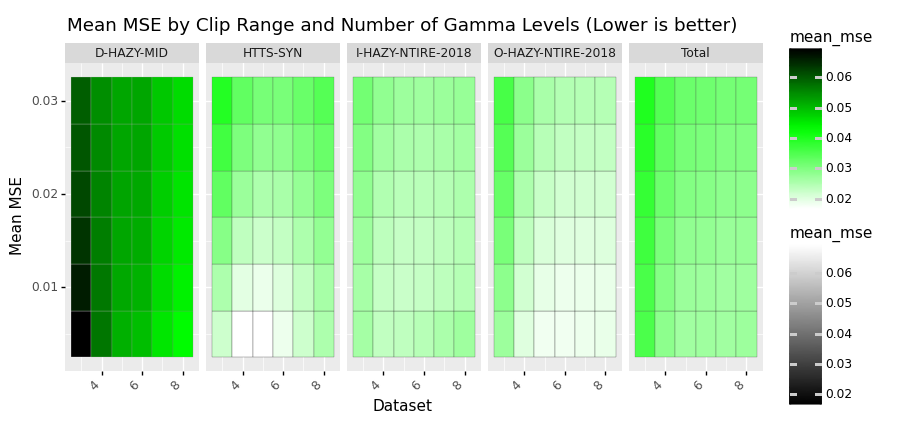

<ggplot: (168247652551)>

In [10]:
Pallette = ["#FFFFFF", "#00FF00", "#000000"]
Outline = ["#000000", "#FFFFFF"]

(ggplot(means_df, aes(x="NumGamma", y="ClipRange", fill="mean_mse", color='mean_mse'))
 + geom_tile()
 + scale_fill_gradientn(Pallette,)
 + scale_color_gradientn(Outline,)
 + facet_grid('. ~ Dataset')
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + theme(figure_size=(9, 4))  # here you define the plot size
 + ggtitle("Mean MSE by Clip Range and Number of Gamma Levels (Lower is better)")
 + labs(x="Dataset", y="Mean MSE")
)

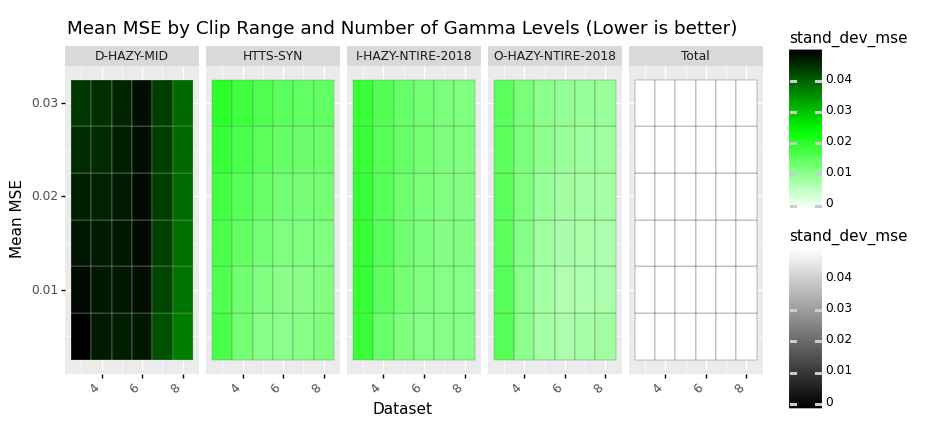

<ggplot: (168247829233)>

In [11]:
Pallette = ["#FFFFFF", "#00FF00", "#000000"]
Outline = ["#000000", "#FFFFFF"]

(ggplot(means_df, aes(x="NumGamma", y="ClipRange", fill="stand_dev_mse", color='stand_dev_mse'))
 + geom_tile()
 + scale_fill_gradientn(Pallette,)
 + scale_color_gradientn(Outline,)
 + facet_grid('. ~ Dataset')
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + theme(figure_size=(9, 4))  # here you define the plot size
 + ggtitle("Mean MSE by Clip Range and Number of Gamma Levels (Lower is better)")
 + labs(x="Dataset", y="Mean MSE")
)

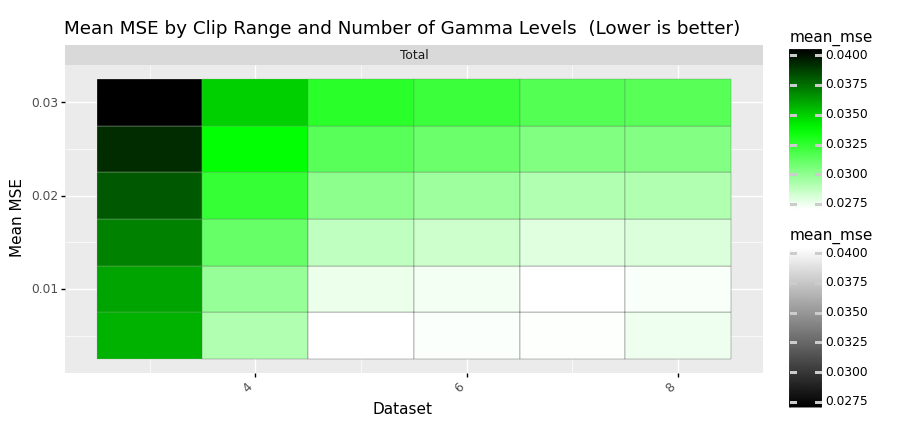

<ggplot: (168247628728)>

In [12]:
Pallette = ["#FFFFFF", "#00FF00", "#000000"]
Outline = ["#000000", "#FFFFFF"]

(ggplot(means_total, aes(x="NumGamma", y="ClipRange", fill="mean_mse", color='mean_mse'))
 + geom_tile()
 + facet_grid('. ~ Dataset')
 + scale_fill_gradientn(Pallette,)
 + scale_color_gradientn(Outline,)
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + theme(figure_size=(9, 4))  # here you define the plot size
 + ggtitle("Mean MSE by Clip Range and Number of Gamma Levels  (Lower is better)")
 + labs(x="Dataset", y="Mean MSE")
)

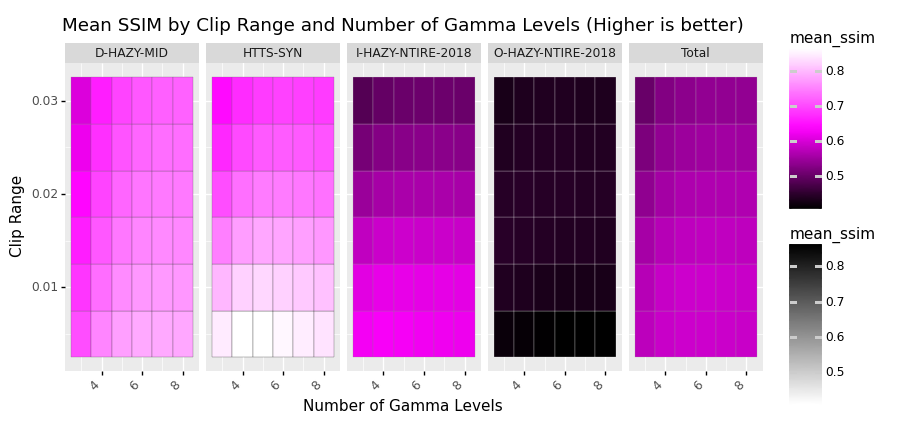

<ggplot: (168247658108)>

In [13]:
Pallette = ["#000000", "#FF00FF", "#FFFFFF"]
Outline = ["#FFFFFF", "#000000"]

(ggplot(means_df, aes(x="NumGamma", y="ClipRange", fill="mean_ssim", color="mean_ssim"))
 + geom_tile()
 + scale_fill_gradientn(Pallette,)
 + scale_color_gradientn(Outline,)
 + facet_grid('. ~ Dataset')
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + theme(figure_size=(9, 4))  # here you define the plot size
 + ggtitle("Mean SSIM by Clip Range and Number of Gamma Levels (Higher is better)")
 + labs(x="Number of Gamma Levels", y="Clip Range")
)

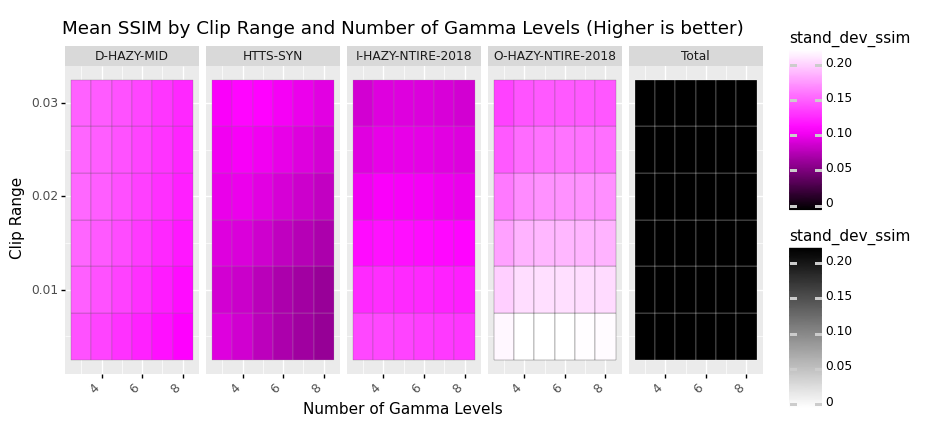

<ggplot: (168249391574)>

In [14]:
Pallette = ["#000000", "#FF00FF", "#FFFFFF"]
Outline = ["#FFFFFF", "#000000"]

(ggplot(means_df, aes(x="NumGamma", y="ClipRange", fill="stand_dev_ssim", color="stand_dev_ssim"))
 + geom_tile()
 + scale_fill_gradientn(Pallette,)
 + scale_color_gradientn(Outline,)
 + facet_grid('. ~ Dataset')
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + theme(figure_size=(9, 4))  # here you define the plot size
 + ggtitle("Mean SSIM by Clip Range and Number of Gamma Levels (Higher is better)")
 + labs(x="Number of Gamma Levels", y="Clip Range")
)

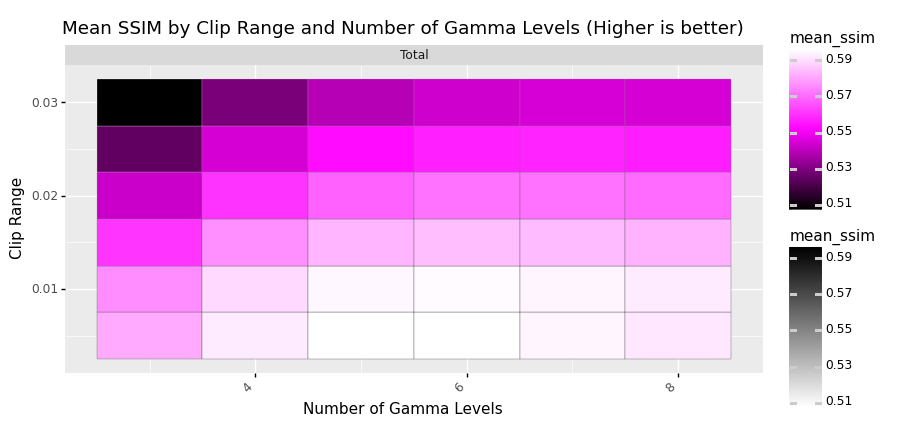

<ggplot: (168249628657)>

In [15]:
(ggplot(means_total, aes(x="NumGamma", y="ClipRange", fill="mean_ssim", color="mean_ssim"))
 + geom_tile()
 + scale_fill_gradientn(Pallette,)
 + scale_color_gradientn(Outline,)
 + facet_grid('. ~ Dataset')
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + theme(figure_size=(9, 4))  # here you define the plot size
 + ggtitle("Mean SSIM by Clip Range and Number of Gamma Levels (Higher is better)")
 + labs(x="Number of Gamma Levels", y="Clip Range")
)

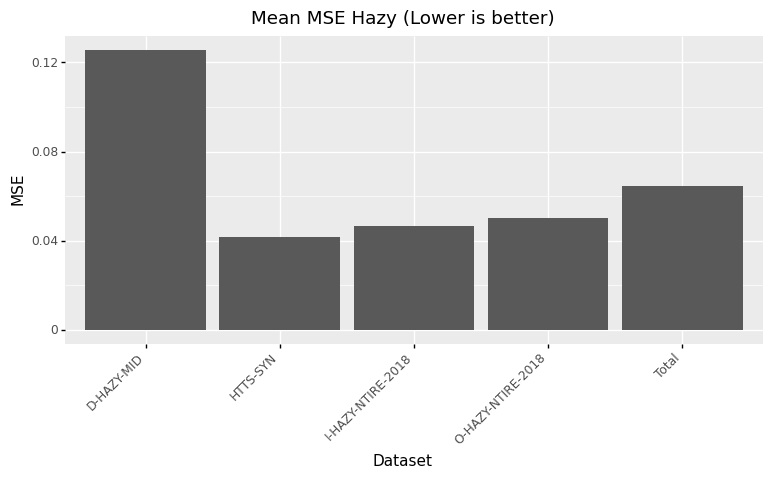

<ggplot: (168249638919)>

In [16]:
(ggplot(means_hazy, aes(x="Dataset", y="mean_mse"))
 + geom_col(stat='identity', position='dodge')
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + theme(figure_size=(9, 4))  # here you define the plot size
 + ggtitle("Mean MSE Hazy (Lower is better)")
 + labs(x="Dataset", y="MSE")
)

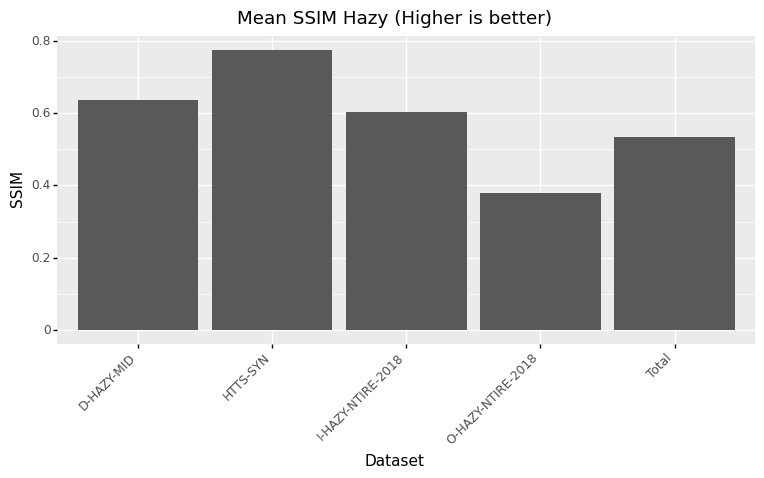

<ggplot: (168249242275)>

In [17]:
(ggplot(means_hazy, aes(x="Dataset", y="mean_ssim"))
 + geom_col(stat='identity', position='dodge')
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + theme(figure_size=(9, 4))  # here you define the plot size
 + ggtitle("Mean SSIM Hazy (Higher is better)")
 + labs(x="Dataset", y="SSIM")
)

In [18]:
data.head()

,Dataset,Filename,Size(Pixels),Method,MSE,SSIM,ClipRange,NumGamma,Time
0,D-HAZY-MID,Adirondack_im0,17176320,HAZY,0.093500,0.686573,0.000,0.0,NaN
1,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.045760,0.768561,0.005,3.0,7.339993
2,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.033644,0.816057,0.005,4.0,8.067115
3,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.026954,0.846020,0.005,5.0,8.692747
4,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.023657,0.862817,0.005,6.0,9.462002


In [19]:
data_hazy.head()

,Dataset,Filename,Size(Pixels),Method,MSE,SSIM,ClipRange,NumGamma,Time
0,D-HAZY-MID,Adirondack_im0,17176320,HAZY,0.093500,0.686573,0.0,0.0,NaN
37,D-HAZY-MID,Backpack_im0,17781120,HAZY,0.043494,0.747612,0.0,0.0,NaN
74,D-HAZY-MID,Bicycle1_im0,17999712,HAZY,0.020871,0.894461,0.0,0.0,NaN
111,D-HAZY-MID,Cable_im0,16641792,HAZY,0.291404,0.529118,0.0,0.0,NaN
148,D-HAZY-MID,Classroom1_im0,17280000,HAZY,0.201291,0.457680,0.0,0.0,NaN


In [20]:
data["rootSize"] = data['Size(Pixels)'] ** (1/2)

In [21]:
isDeHazed = data['Method'] == "AMEF"
data_dehazed = data[isDeHazed]

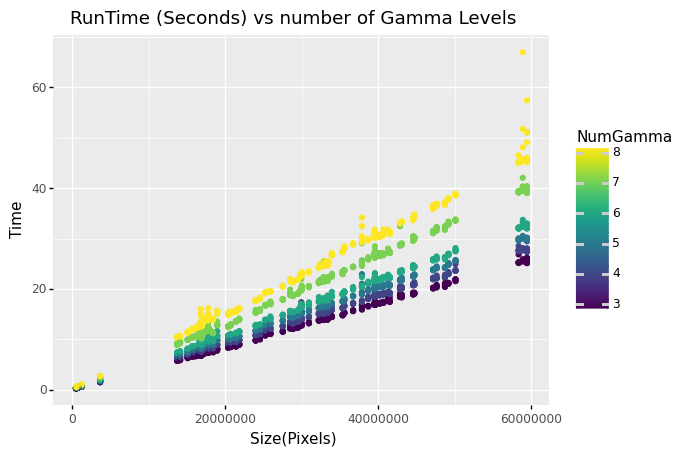

<ggplot: (168249696865)>

In [22]:
(ggplot(data_dehazed, aes(x="Size(Pixels)", y="Time", color="NumGamma"))
+ geom_point()
+ ggtitle("RunTime (Seconds) vs number of Gamma Levels"))

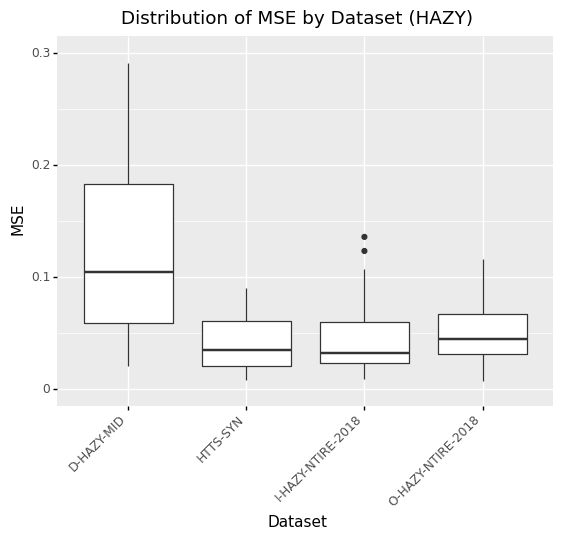

<ggplot: (168249265192)>

In [23]:
(ggplot(data_hazy, aes(x="Dataset", y="MSE"))
+ geom_boxplot()
+ ylim(0,0.3)
+ theme(axis_text_x=element_text(rotation=45, hjust=1))
+ ggtitle("Distribution of MSE by Dataset (HAZY)"))

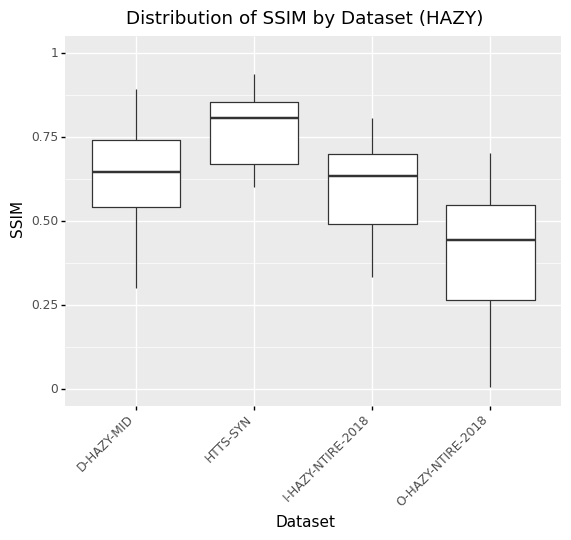

<ggplot: (168249693272)>

In [24]:
(ggplot(data_hazy, aes(x="Dataset", y="SSIM", ymax=1, ymin=0))
+ geom_boxplot()
+ ylim(0,1)
+ theme(axis_text_x=element_text(rotation=45, hjust=1))
+ ggtitle("Distribution of SSIM by Dataset (HAZY)"))

In [25]:
for i, cr in enumerate(crs):
    for j, ng in enumerate(ngs):
        ssimTitle = 'Distribution of SSIM by Dataset (CR = {c}, NumGamma = {g})'.format(c = cr, g = ng)
        mseTitle = 'Distribution of MSE by Dataset (CR = {c}, NumGamma = {g})'.format(c = cr, g = ng)
        ssimFN = './Figures/ssim_{c}_{g}.png'.format(c = cr, g = ng)
        mseFN = './Figures/mse_{c}_{g}.png'.format(c = cr, g = ng)
        ssim = (ggplot(data_cr_ng[i][j], aes(x="Dataset", y="SSIM"))
            + geom_boxplot()
            + ylim(0,1)
            + theme(axis_text_x=element_text(rotation=45, hjust=1))
            + ggtitle(ssimTitle))
        ssim.save(filename=ssimFN)
        mse = (ggplot(data_cr_ng[i][j], aes(x="Dataset", y="MSE"))
            + geom_boxplot()
            + ylim(0,0.3)
            + theme(axis_text_x=element_text(rotation=45, hjust=1))
            + ggtitle(mseTitle))
        mse.save(filename=mseFN)

In [26]:
means_df.head()

,Dataset,Method,ClipRange,NumGamma,mean_mse,mean_ssim,stand_dev_mse,stand_dev_ssim
0,D-HAZY-MID,AMEF,0.005,3.0,0.068046,0.700802,0.048634,0.141584
1,HTTS-SYN,AMEF,0.005,3.0,0.023096,0.832928,0.017304,0.094085
2,I-HAZY-NTIRE-2018,AMEF,0.005,3.0,0.026975,0.627287,0.018994,0.137647
3,O-HAZY-NTIRE-2018,AMEF,0.005,3.0,0.027831,0.429317,0.016232,0.211338
4,Total,AMEF,0.005,3.0,0.035719,0.579496,0.000000,0.000000


In [27]:
hz_DHZ=pd.read_csv("../dataDHZ.csv")
hz_DHZ=pd.concat([hz_DHZ]*37)
hz_DHZ=hz_DHZ.rename(columns={"0": "name", "1": "mean", "2": "std"})
hz_DHZ=hz_DHZ.sort_values(by=['name'])

hz_HTS=pd.read_csv("../dataHTS.csv")
hz_HTS=pd.concat([hz_HTS]*37)
hz_HTS=hz_HTS.rename(columns={"0": "name", "1": "mean", "2": "std"})
hz_HTS=hz_HTS.sort_values(by=['name'])

hz_IHZ=pd.read_csv("../dataIHZ.csv")
hz_IHZ=pd.concat([hz_IHZ]*37)
hz_IHZ=hz_IHZ.rename(columns={"0": "name", "1": "mean", "2": "std"})
hz_IHZ=hz_IHZ.sort_values(by=['name'])

hz_OHZ=pd.read_csv("../dataOHZ.csv")
hz_OHZ=pd.concat([hz_OHZ]*37)
hz_OHZ=hz_OHZ.rename(columns={"0": "name", "1": "mean", "2": "std"})
hz_OHZ=hz_OHZ.sort_values(by=['name'])


In [28]:
hz_DHZ.head()

,name,mean,std
0,Adirondack_Hazy.bmp,0.9868,0.0888
0,Adirondack_Hazy.bmp,0.9868,0.0888
0,Adirondack_Hazy.bmp,0.9868,0.0888
0,Adirondack_Hazy.bmp,0.9868,0.0888
0,Adirondack_Hazy.bmp,0.9868,0.0888


In [29]:
hz = pd.concat([hz_DHZ,hz_HTS,hz_IHZ,hz_OHZ]).reset_index()

In [30]:
data = data.reset_index()

In [31]:
hz.head()

,index,name,mean,std
0,0,Adirondack_Hazy.bmp,0.9868,0.0888
1,0,Adirondack_Hazy.bmp,0.9868,0.0888
2,0,Adirondack_Hazy.bmp,0.9868,0.0888
3,0,Adirondack_Hazy.bmp,0.9868,0.0888
4,0,Adirondack_Hazy.bmp,0.9868,0.0888


In [32]:
hz.shape

(3996, 4)

In [33]:
data['Haziness'] = hz['mean']

In [42]:
isDeHazed = data['Method'] == "AMEF"
data_dehazed = data[isDeHazed]

is6Gamma = data['NumGamma'] == 6
data_dehazed = data_dehazed[is6Gamma]

In [43]:
data_dehazed.head(40)

,index,Dataset,Filename,Size(Pixels),Method,MSE,SSIM,ClipRange,NumGamma,Time,rootSize,Haziness
4,4,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.023657,0.862817,0.005,6.0,9.462002,4144.432410,0.9868
10,10,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.024838,0.849034,0.010,6.0,9.197295,4144.432410,0.9868
16,16,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.025527,0.836909,0.015,6.0,9.264420,4144.432410,0.9868
22,22,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.025841,0.824744,0.020,6.0,9.276107,4144.432410,0.9868
28,28,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.025872,0.812593,0.025,6.0,9.220521,4144.432410,0.9868
34,34,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.025714,0.800743,0.030,6.0,9.319964,4144.432410,0.9868
41,41,D-HAZY-MID,Backpack_im0,17781120,AMEF,0.019385,0.876344,0.005,6.0,9.672282,4216.766534,0.9788
47,47,D-HAZY-MID,Backpack_im0,17781120,AMEF,0.019801,0.861645,0.010,6.0,9.628555,4216.766534,0.9788
53,53,D-HAZY-MID,Backpack_im0,17781120,AMEF,0.020165,0.855186,0.015,6.0,9.560292,4216.766534,0.9788
59,59,D-HAZY-MID,Backpack_im0,17781120,AMEF,0.020438,0.852000,0.020,6.0,9.647505,4216.766534,0.9788


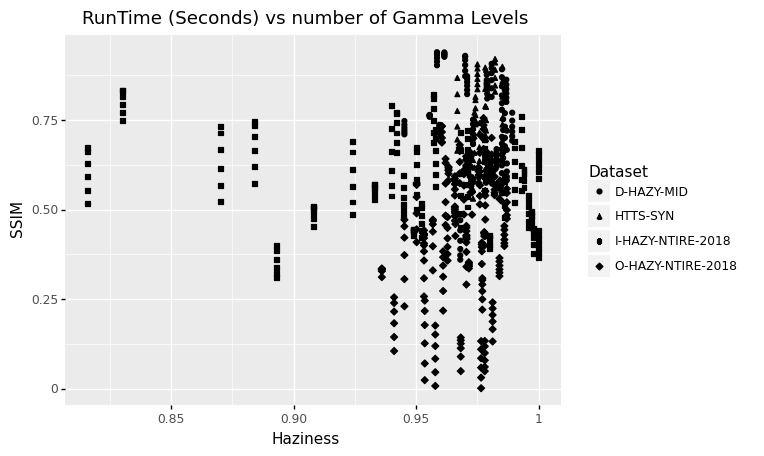

<ggplot: (168254216656)>

In [45]:
(ggplot(data_dehazed, aes(x="Haziness", y="SSIM", shape="Dataset"))
+ geom_point()
+ ggtitle("RunTime (Seconds) vs number of Gamma Levels"))

In [46]:
hzMSE = pd.DataFrame(columns = data_hazy.columns)
hzSSIM = pd.DataFrame(columns = data_hazy.columns)

nameCurr = ""
namePrev = ""
minMSE = 1
maxSSIM = 0
started = False
bestMSE = None
bestSSIM = None
for row in data_dehazed.iterrows():
    nameCurr = row[1]["Filename"]
    
    if nameCurr != namePrev and started:
        hzMSE = hzMSE.append(bestMSE, ignore_index=True)
        hzSSIM = hzSSIM.append(bestSSIM, ignore_index=True)
    
        bestMSE = None
        bestSSIM = None
        minMSE = 1
        maxSSIM = 0
        
    started = True
        
    if row[1]['MSE'] < minMSE:
        bestMSE = row[1]
        minMSE = row[1]['MSE']
    
    if row[1]['SSIM'] > maxSSIM:
        bestSSIM = row[1]
        maxSSIM = row[1]['SSIM']
        
    namePrev = nameCurr

In [47]:
hzMSE.head()

,Dataset,Filename,Size(Pixels),Method,MSE,SSIM,ClipRange,NumGamma,Time,Haziness,index,rootSize
0,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.023657,0.862817,0.005,6.0,9.462002,0.9868,4.0,4144.432410
1,D-HAZY-MID,Backpack_im0,17781120,AMEF,0.019385,0.876344,0.005,6.0,9.672282,0.9788,41.0,4216.766534
2,D-HAZY-MID,Bicycle1_im0,17999712,AMEF,0.009292,0.926103,0.010,6.0,9.662446,0.9700,84.0,4242.606746
3,D-HAZY-MID,Cable_im0,16641792,AMEF,0.176922,0.609369,0.005,6.0,9.037656,0.9785,115.0,4079.435255
4,D-HAZY-MID,Classroom1_im0,17280000,AMEF,0.050411,0.703354,0.005,6.0,9.402327,0.9850,152.0,4156.921938


In [48]:
hzSSIM.head()

,Dataset,Filename,Size(Pixels),Method,MSE,SSIM,ClipRange,NumGamma,Time,Haziness,index,rootSize
0,D-HAZY-MID,Adirondack_im0,17176320,AMEF,0.023657,0.862817,0.005,6.0,9.462002,0.9868,4.0,4144.432410
1,D-HAZY-MID,Backpack_im0,17781120,AMEF,0.019385,0.876344,0.005,6.0,9.672282,0.9788,41.0,4216.766534
2,D-HAZY-MID,Bicycle1_im0,17999712,AMEF,0.009540,0.929356,0.005,6.0,9.613029,0.9700,78.0,4242.606746
3,D-HAZY-MID,Cable_im0,16641792,AMEF,0.176922,0.609369,0.005,6.0,9.037656,0.9785,115.0,4079.435255
4,D-HAZY-MID,Classroom1_im0,17280000,AMEF,0.050411,0.703354,0.005,6.0,9.402327,0.9850,152.0,4156.921938


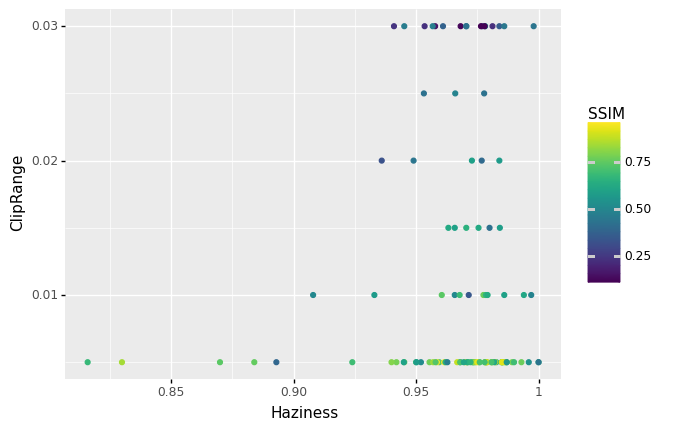

<ggplot: (168250677935)>

In [85]:
(ggplot(hzSSIM, aes(x="Haziness", y="ClipRange", color="SSIM"))
+ geom_point())
# + facet_grid("ClipRange ~ NumGamma")

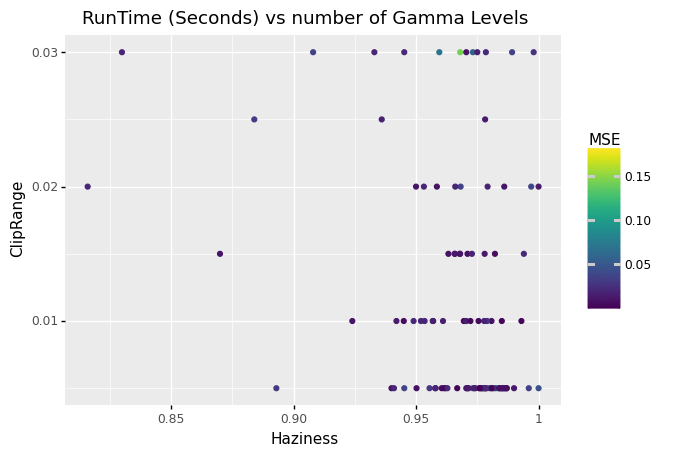

<ggplot: (168248078662)>

In [60]:
(ggplot(hzMSE, aes(x="Haziness", y="ClipRange", color="MSE"))
+ geom_point()
#  + geom_jitter()
# + facet_grid("ClipRange ~ NumGamma")
+ ggtitle("RunTime (Seconds) vs number of Gamma Levels"))

In [83]:
z = np.polyfit(hzSSIM["Haziness"], hzSSIM["ClipRange"], 2)
print(str(round(z[0],3)) + "x^2 + " + str(round(z[1],3)) + "x + " + str(round(z[2],3)) )

-0.757x^2 + 1.423x + -0.656


In [71]:
p = np.poly1d(z)
hzSSIM["CRPred"] = p(hzSSIM["Haziness"])

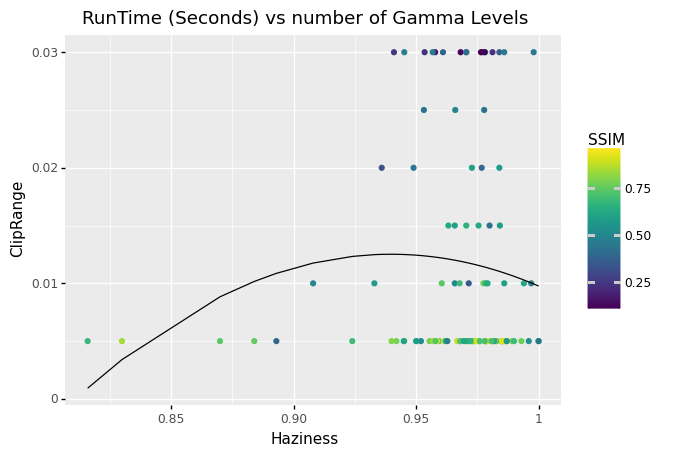

<ggplot: (168250670309)>

In [80]:
(ggplot(hzSSIM, aes(x="Haziness", y="ClipRange"))
+ geom_point(aes(color="SSIM"))
+ geom_line(aes(y="CRPred"))
+ geom_text()
# + facet_grid("ClipRange ~ NumGamma")
+ ggtitle("RunTime (Seconds) vs number of Gamma Levels"))